In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pywt
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt

In [ ]:
main_dir = "/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/test/pkz files"
bearing = ['Bearing1_3']

DATA_POINTS_PER_FILE = 2560
TIME_PER_REC = 0.1
SAMPLING_FREQ = 25600 # 25.6 KHz
SAMPLING_PERIOD = 1.0/SAMPLING_FREQ

WIN_SIZE = 20
WAVELET_TYPE = 'morl'

In [ ]:
def load_file(pkz_file):
    with open(pkz_file, 'rb') as f:
        df=pkl.load(f)
    return df

def df_row_ind_to_data_range(ind):
    return (DATA_POINTS_PER_FILE*ind, DATA_POINTS_PER_FILE*(ind+1))

def extract_feature_image(ind, feature_name='horiz accel'):
    data_range = df_row_ind_to_data_range(ind)
    data = df[feature_name].values[data_range[0]:data_range[1]]
    # use window to process(= prepare, develop) 1d signal
    data = np.array([np.mean(data[i:i+WIN_SIZE]) for i in range(0, DATA_POINTS_PER_FILE, WIN_SIZE)])  
    # perform cwt on 1d data
    coef, _ = pywt.cwt(data, np.linspace(1,128,128), WAVELET_TYPE)  
    # transform to power and apply logarithm ?!
    coef = np.log2(coef**2+0.001) 
    # normalize coef
    coef = (coef - coef.min())/(coef.max() - coef.min()) 
    return coef

def signal_processing():
  no_of_samples = 5
  fig, ax = plt.subplots(2, no_of_samples, figsize=[20,8])
  ax[0,0].set_ylabel('horiz accel features image')
  ax[1,0].set_ylabel('vert accel features image')

  # dividing the feature images into 5 samples
  for i,p in enumerate(np.linspace(0,1,no_of_samples)):
    ind = int( (no_of_files-1)*p)

  # extracting and plotting horizontal accelration feature images for 5 samples
    coef = extract_feature_image(ind, feature_name='horiz accel') 
    ax[0,i].set_title('{0:.2f}'.format(p))
    im = ax[0,i].imshow(coef, cmap = 'coolwarm')
    fig.colorbar(im, ax = ax[0,i], fraction=0.046, pad=0.04)

  # extracting and plotting vertical accleration feature images for 5 samples
    coef = extract_feature_image(ind, feature_name='vert accel')
    ax[1,i].set_title('{0:.2f}'.format(p))
    im = ax[1,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax = ax[1,i], fraction=0.046, pad=0.04)

  plt.tight_layout()
  plt.show()

def extract_2d_feature():
    data = {'x': [], 'y': []}
    for i in range(0, no_of_files):
        coef_h = extract_feature_image(i, feature_name='horiz accel') # size = (128,128)
        coef_v = extract_feature_image(i, feature_name='vert accel')  # size = (128,128)

        x_ = np.array( [coef_h, coef_v] ) # size = (2,128,128)
        y_ = i/(no_of_files - 1) 
        data['x'].append(x_)
        data['y'].append(y_)

    data['x'] = np.array(data['x'])
    data['y'] = np.array(data['y'])

    assert data['x'].shape == (no_of_files, 2, 128, 128)
    print(no_of_files, data['x'].shape, data['y'].shape)
    
    return data

def save_file(bearing,data):
   path = "/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/test/1d_2d_merged_data"
   file = os.path.join(path, bearing + ".pkz")
   with open(file, 'wb') as f:
     pkl.dump(data,f)

**Bearing1_3**

In [ ]:
pkz_file = os.path.join(main_dir, "Bearing1_3.pkz")
df = load_file(pkz_file)
df.head()

,hour,minute,second,microsecond,horiz accel,vert accel
0,8,33,1,378160.0,0.092,0.044
1,8,33,1,378200.0,-0.025,0.432
2,8,33,1,378240.0,-0.104,0.008
3,8,33,1,378280.0,0.056,-0.264
4,8,33,1,378320.0,0.074,-0.195


In [ ]:
no_of_rows = df.shape[0]
no_of_files = int(no_of_rows / DATA_POINTS_PER_FILE)
print(no_of_rows, no_of_files)

4613120 1802


**Plotting 1D Vibration Signals (both horiz accel & vert accel)**

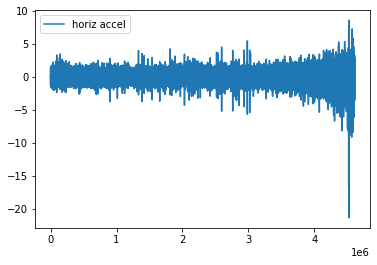

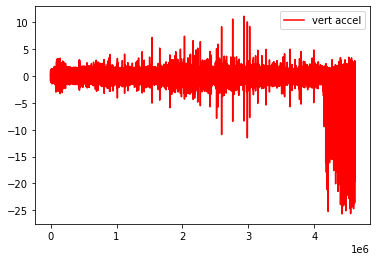

In [ ]:
plt.plot(range(no_of_rows), df['horiz accel'])
plt.legend(['horiz accel'])
plt.show()
plt.plot(range(no_of_rows), df['vert accel'], 'r')
plt.legend(['vert accel'])
plt.show()

**Signal Processing** **=** **Extracting Time-Frequency Domain Feature Images**

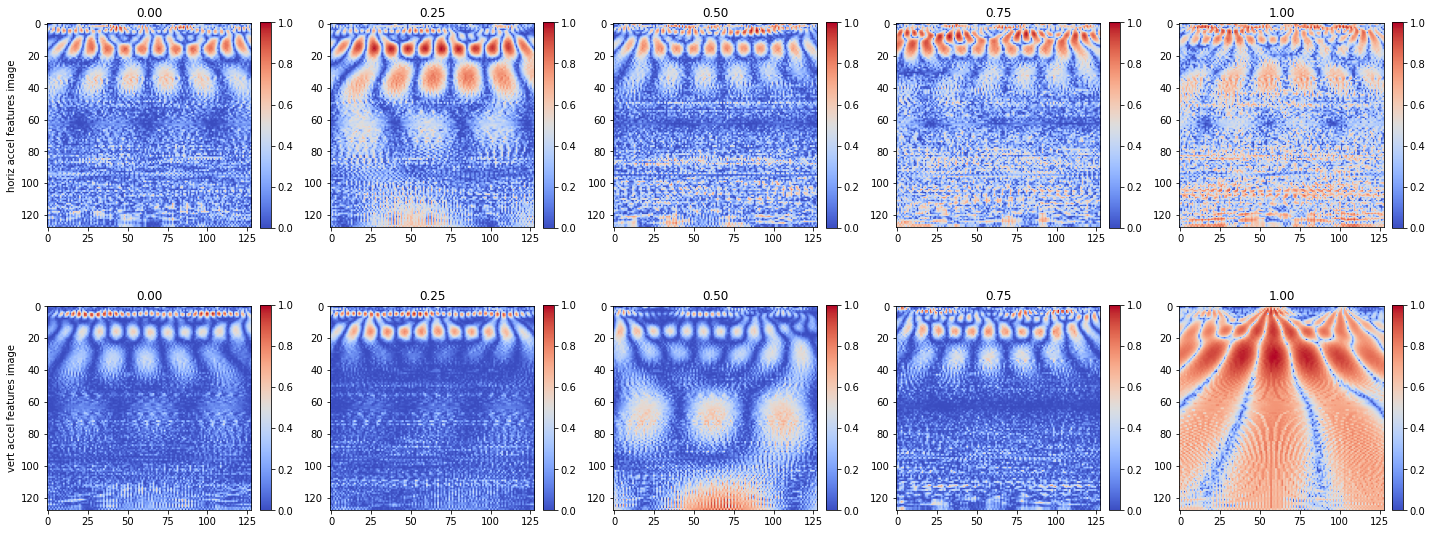

In [ ]:
signal_processing()

**Extracting 2D feature Images for each Data File in Bearing1_3 & converting into numpy array**

In [ ]:
data = extract_2d_feature()

1802 (1802, 2, 128, 128) (1802,)


**Saving as pickle files(.pkz files)**

In [ ]:
save_file('Bearing1_3', data)